<h1 align="center">Cross Validation</h1>

<br>

This tutorial is based on the book *An Introduction to Statistical Learning*, which is fully accessible online ([link](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf))

<h3 align="left">Overview of the tutorial</h3>

- Cross validation in detail
- (Train | Test) split
- (Train | Validation | Test) split
- Scikit-learn cross_val_score
- Scikit-learn cross_validate
- Grid Search

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. In a prediction problem, a model is usually trained on a dataset of known data (training dataset), and tested on a dataset of unknown data (validation dataset or testing dataset). The goal of cross-validation is to test the model's ability to predict the values of the response variable on new data that was not used on the training process. This gives an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<br>

<h2 aling="left">(Train | Test) split</h2>

In [3]:
df = pd.read_csv("C:/Users/testi/Desktop/ML/DATA/Advertising.csv")

In [4]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


**(Train | Test) split procedure**
1. Clean and adjust data as necessary for X and y
2. Split data in train / test sets for both X and y
3. Fit / train scaler on X_train data
4. Scale X test data
5. Create model
6. Fit / train model on training data
7. Evaluate model on X_test data (by creating predictions and comparing to y_test)
8. Adjust parameters as necessary
9. Repeat steps 6 and 7

In [5]:
# Features
X = df.drop("sales", axis=1)

In [6]:
# Label
y = df["sales"]

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()

In [11]:
# Recall, that you only fit to the training data
# (otherwise you are assuming prior information about the test set)
scaler.fit(X_train)

StandardScaler()

In [12]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Create the model. Let's choose a Ridge model.
# This way we'll actually have hyper parameters to adjust.
from sklearn.linear_model import Ridge

In [14]:
# Create the model (choose some alpha value)
model = Ridge(alpha=100)

In [15]:
# Fit the model on the training data
model.fit(X_train, y_train)

Ridge(alpha=100)

In [16]:
# Create the predictions
y_pred = model.predict(X_test)

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
# Evaluate the model using your chosen performance metrics
mean_squared_error(y_test, y_pred)

7.341775789034128

- Now we need to adjust the parameters as necessary.
- So we need to figure out if there is a better value for alpha.
- However, when doing just a simple train test split, you are really limited on your options.
- You could maybe create a for loop that checks different alpha values and go from there, but essentially you are going to just guess the alpha value and check the performance.

In [19]:
# Create another model and use a different alpha value
model_two = Ridge(alpha=1)

In [20]:
model_two.fit(X_train, y_train)

Ridge(alpha=1)

In [21]:
y_pred_two = model_two.predict(X_test)

In [22]:
# Evaluate the performance of the new model
mean_squared_error(y_test, y_pred_two)

2.319021579428752

- The Ridge model clearly performs better when alpha=1 compared to alpha=100.
- However, this procedure of creating a new model with different alpha value over and over again is clearly not productive.
- Also, with (Train | Test) split method, does not have a portion of data that can report a performance metric on truly unseen data.
- This is because when fitting a new model and seeking for a better performance, we are tuning the hyperparameters based on the previous values obtained, so in some sense, the model has already seen the training data before.
    
    $\, \rightarrow \,$ this "problem" can be tackled with a **validation set**.

<br> 

<h2 align="left">(Train | Validation | Test) split</h2>

- For the (train | validation | test) split we simply perform train_test_split twice.
- (For an easier interpretation, i'm going to make the features, labels, and import the necessary libraries again. \
Note that you don't have to do this again)

In [23]:
# Features
X = df.drop("sales", axis=1)

In [24]:
# Label
y = df["sales"]

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# First train test split.
X_train, X_temporary, y_train, y_temporary = train_test_split(X, 
                                                              y, 
                                                              test_size=0.3, 
                                                              random_state=101)

In [27]:
# Second train test split
X_validation, X_test, y_validation, y_test = train_test_split(X_temporary,
                                                              y_temporary,
                                                              test_size=0.5,
                                                              random_state=101)
# Note that X_temporary and y_temporary hold 30 % of the data.
# Therefore, when we perform the second train test split with test_size=0.5, \
# we end up having test size of 15 % (50 % from 30 % ---> 15 % from all of the data)

In [28]:
len(df)

200

In [29]:
# 70 % of the data
print(len(X_train))
print(len(y_train))

140
140


In [30]:
0.7 * 200

140.0

In [31]:
# 15 % of the data
print(len(X_validation))
print(len(y_validation))

30
30


In [32]:
# 15 % of the data
print(len(X_test))
print(len(y_test))

30
30


In [33]:
0.15*200

30.0

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()

In [36]:
# Remember to only fit to the training data
scaler.fit(X_train)

StandardScaler()

- Since the model will be trained on scaled data, it can only validate its performance on scaled data.
- Therefore, we're going to have to also scale both the validation set and test set.

In [37]:
# Scale X_train, X_test, X_validation
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_validation = scaler.transform(X_validation)

In [38]:
from sklearn.linear_model import Ridge

In [39]:
# Create the model
M1 = Ridge(alpha=100)

In [40]:
# Fit to training data
M1.fit(X_train, y_train)

Ridge(alpha=100)

In [41]:
# Calculate the predictions on validation set
y_validation_pred1 = M1.predict(X_validation)

In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
# Calculate the performance metric for the model
mean_squared_error(y_validation, y_validation_pred1)

7.320101458823869

In [44]:
# Again, we are tuning the hyperparameter based on the previous performance metric value obtained
M2 = Ridge(alpha=1)

In [45]:
# Fit the new model to the training data
M2.fit(X_train, y_train)

Ridge(alpha=1)

In [46]:
# Calculate the predictions
y_validation_pred2 = M2.predict(X_validation)

In [47]:
# Calculate performance
mean_squared_error(y_validation, y_validation_pred2)

2.383783075056986

- Let's say that we are fully satisfied with this performance metric value (i.e. choose this model as the final model)
- This is where the test set comes into play.
    - Recall that we have not used the test set before until this point to train the model or to test its performance.
    - Therefore, it can be used as a fair evaluation set on the model's performance on a truly unseen data.
- After predicting the label values on the test set, you can't adjust the hyperparameters anymore.

In [48]:
y_final_test_pred = M2.predict(X_test)

In [49]:
mean_squared_error(y_test, y_final_test_pred)

2.2542600838005176

- This is the final test metric to report on your model's performance.

<br>

<h2 align="left">cross_val_score</h2>

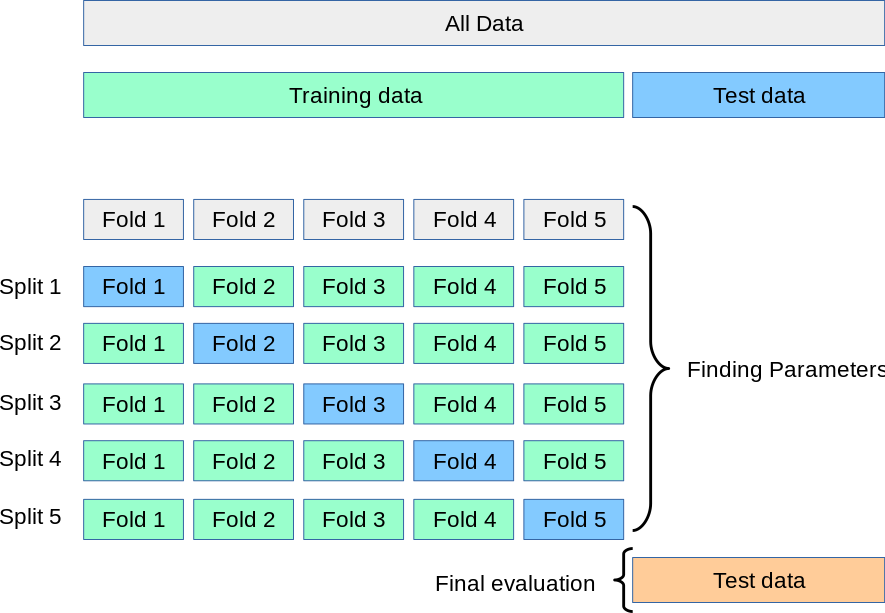

In [50]:
# Features
X = df.drop("sales", axis=1)

In [51]:
# Label
y = df["sales"]

In [52]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [57]:
from sklearn.model_selection import train_test_split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
scaler = StandardScaler()

In [80]:
# Remember that you fit only to the training data
scaler.fit(X_train)

StandardScaler()

In [81]:
# Scale the training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [92]:
# Create the model with an arbitrary alpha value
model1 = Ridge(alpha=1)

In [93]:
from sklearn.model_selection import cross_val_score

In [94]:
scores = cross_val_score(model1, 
                         X_train, 
                         y_train,
                         cv=5,
                         scoring="neg_mean_squared_error")

- For the cross_val_score function, we pass in 
    - the model (estimator)
    - X_train
    - y_train
    - cv (K value for the K-fold cross validation)
    - the scoring metric
        - (see link for all the available scoring metrics: https://scikit-learn.org/stable/modules/model_evaluation.html)
        - recall that the scoring metric parameters follow a uniform scoring style in sklearn
            - $\rightarrow$ higher scoring metric value equals better performance

In [95]:
scores

array([-3.15513238, -1.58086982, -5.40455562, -2.21654481, -4.36709384])

- Since cv=5, we are a using 5-fold cross-validation. 
- This means that the data is split into 5 folds or subsets. 
- The model is trained and evaluated 5 times, each time using a different fold as the test set and the remaining folds as the training set.
- The cross_val_score function returns an array of scores, where each score represents the evaluation result (scoring metric value) for a specific fold. 
- In our case, since cv=5, we get an array of 5 scores, one for each fold.
- These scores are typically used to assess the model's performance and can be used to calculate metrics such as mean squared error (MSE)

In [96]:
# To get the MSE, we can take the absolute value of the mean of the scores
abs(scores.mean())

3.344839296530695

Note. We have not fitted the model on the training data yet. The model was only fit within the cross_val_score function in order to produce the scores. We actually need to fit the model on all of the training data again in order to perform the final evaluation.

In [97]:
# Fit the model to the training data
model1.fit(X_train, y_train)

Ridge(alpha=1)

In [98]:
label_preds = model1.predict(X_test)

In [101]:
from sklearn.metrics import mean_squared_error

In [102]:
mean_squared_error(y_test, label_preds)

2.319021579428752

- This is now the final MSE to report.

If you want, you can easily create your own MSE function.

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2, $$

where $y_i$ are the true observed values and $\hat{y_i}$ are the predicted values.

In [115]:
def MSE(y_test, y_pred):
    return (1/len(y_pred)) * sum(y_test - y_pred)**2

In [116]:
MSE(y_test, label_preds)

2.1139276068973083

- The slight difference in the value of the MSE compared to sklearn's MSE is probably due to roundings of the floats.

<br>

<h2 align="left">cross_validate</h2>

- The cross_validate function is really similar to the cross_val_score function.
- Instead of specifying only one scoring metric, we can simultaneously evaluate on multiple scoring metrics.

In [117]:
from sklearn.model_selection import cross_validate

Let's use the fitted model and training data from the cross_val_score section above.

In [118]:
cross_validate(model1,
               X_train,
               y_train,
               cv=5,
               scoring=["neg_mean_squared_error",
                        "neg_mean_absolute_error"])

{'fit_time': array([0.00199485, 0.        , 0.00099683, 0.00099707, 0.        ]),
 'score_time': array([0.        , 0.00099778, 0.        , 0.        , 0.00099993]),
 'test_neg_mean_squared_error': array([-3.15513238, -1.58086982, -5.40455562, -2.21654481, -4.36709384]),
 'test_neg_mean_absolute_error': array([-1.54711694, -1.02604449, -1.40079299, -1.15425141, -1.47022164])}

- The interpretation is really hazy. This can be fixed with Pandas.

In [119]:
scores2 = cross_validate(model1,
                         X_train,
                         y_train,
                         cv=5,
                         scoring=["neg_mean_squared_error",
                                  "neg_mean_absolute_error"])

In [130]:
pd.DataFrame(scores2)

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,0.000000,0.000998,-3.155132,-1.547117
1,0.000997,0.000000,-1.580870,-1.026044
2,0.000997,0.000000,-5.404556,-1.400793
3,0.000000,0.000000,-2.216545,-1.154251
4,0.000000,0.000000,-4.367094,-1.470222


<br>

<h2 align="left">Grid Search</h2>

- A **grid search** is a way of training and validating a model on every possible combination of multiple hyperparameter options.
- Scikit-Learn includes a **GridSearchCV** class that is capable of testing a dictionary of multiple hyperparameter options through cross-validation.
- This allows for both cross-validation and a grid search to be performed in a generalized way for any model.

In [131]:
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [136]:
# For the sake of interpretation, let's quickly review the steps for setting up the data.

# Create the features and the label
X = df.drop("sales", axis=1)
y = df["sales"]

# Perform train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=101)
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's work with the **Elastic Net**. This way we'll have multiple hyperparameters to adjust. \
Elastic Net can be expressed as follows

\begin{equation*}
    \displaystyle\large\frac{{\sum_{i=1}^{n} (y_i - x_i^J\hat{\beta})^2}} {2n} + \lambda \left(\frac{1 - \alpha} {2} \sum_{j=1}^{m} \hat{\beta}_j^2 + \alpha \sum_{j=1}^{m} |\hat{\beta_j}| \right).
\end{equation*}

The Elastic Net model is a linear regression model that combines the L1 regularization (LASSO) and L2 regularization (Ridge) techniques. 


The Elastic Net model adds a penalty term to the traditional linear regression objective function (RSS, the Residual Sum of Squares, which linear regression aims to minimize), which consists of two components: the L1 norm of the regression coefficients and the L2 norm of the regression coefficients. 
- The L1 norm encourages sparsity in the model by shrinking some coefficients to exactly zero, effectively performing feature selection. 


- The L2 norm encourages small but non-zero coefficients, which helps in handling multicollinearity and stabilizing the model.
    
The Elastic Net model introduces two hyperparameters, **alpha** ($\boldsymbol{\alpha}$) and **lambda** ($\boldsymbol{\lambda}$). 
- The $\boldsymbol{\alpha}$ parameter controls the mixture between L1 and L2 regularization, with a value of 1 representing pure LASSO regression and a value of 0 representing pure Ridge regression. 
- If you take a look at the equation above, you'll understand why; 

<center>if $\alpha$ is equal to zero, then $\, \alpha \sum_{j=1}^{m} |\hat{\beta_j}| \,$ (LASSO penalty term) cancels.<center>
    
    
<center>On the other hand, if $\alpha$ is equal to 1, then $\, \frac{1 - \alpha}{2} \sum_{j=1}^{m} \hat{\beta_j^2} \,$ (Ridge penalty term) cancels.<center>

- The $\boldsymbol{\lambda}$ parameter controls the overall strength of the regularization

    $\, \boldsymbol{\rightarrow} $  the larger $\, \boldsymbol{\lambda} \,$ is, the greater the magnitude of the penalty will be.
    
    
- When lambda is increased, the penalty term becomes larger, leading to a stronger regularization
    
    $\, \boldsymbol{\rightarrow} $ as a result, the coefficients of the regression model are penalized more heavily, and their magnitudes tend to be smaller.

In [139]:
from sklearn.linear_model import ElasticNet

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


- **IMPORTANT!!** In Sklearn's ElasticNet class, **alpha** parameter is the $\, \boldsymbol{\lambda} \,$ constant that controls the overall strength of the regularization (see Elastic Net's equation above), and the value(**s**) of **l1_ratio** parameter controls the mixture between L1 and L2 regularization.

In [140]:
base_elastic_net_model = ElasticNet()

In [1]:
# Pass the hyperparameters that you want to tune from the ElasticNet class in to a dictionary as keys.
# Note that the keys (as strings) need to match exactly the parameters from the ElasticNet class call.
# Then you pass in the values that you want to check.
# Note that alpha=lambda, l1_ratio = the ratio for how much to use L1 (LASSO) and L2 (Ridge).
# The closer l1_ratio is to zero, the more you use L1 penalty (closer to 1 ---> more L2 penalty).
# You can pass in a list of values between 0 and 1 to l1_ratio.
# Likewise for the alpha (lambda) parameter you can pass a list of values.

param_grid = {"alpha":[0.1, 1, 5, 10, 50, 100], 
              "l1_ratio": [0.1, 0.5, 0.7, 0.95, 0.99, 1]}

In [146]:
from sklearn.model_selection import GridSearchCV

- So what Grid search does, it tries every single combination of the values  that we provided.
- For example, it's going to try the alpha value of 0.1 with all of the l1_ratio values: 0.1, 0.5, 0.7, 0.95, 0.99 and 1.

In [152]:
# Create the Grid model.
# you pass in your model, the dictionary, scoring parameter, K value for K-fold cross-validation, \
# and verbose parameter value, which controls the amount of information to display.

grid_model = GridSearchCV(base_elastic_net_model,
                          param_grid=param_grid,
                          scoring="neg_mean_squared_error",
                          cv=5,
                          verbose=1)

In [153]:
# Fit the Grid model on the training data
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [154]:
# Fetch the performing best model
grid_model.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=1)

- The **best model** was obtained using an **alpha (lambda) value of 0.1**, and **l1_ratio of 1** (so basically L2 regularization)

In [156]:
# Info on all of the different combinations of alpha and l1_ratio values
pd.DataFrame(grid_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000799,0.000400,0.000399,0.000489,0.1,0.1,"{'alpha': 0.1, 'l1_ratio': 0.1}",-3.453021,-1.405190,-5.789125,-2.187302,-4.645576,-3.496043,1.591601,6
1,0.000996,0.000002,0.000000,0.000000,0.1,0.5,"{'alpha': 0.1, 'l1_ratio': 0.5}",-3.325440,-1.427522,-5.595610,-2.163089,-4.451679,-3.392668,1.506827,5
2,0.000604,0.000493,0.000000,0.000000,0.1,0.7,"{'alpha': 0.1, 'l1_ratio': 0.7}",-3.269880,-1.442432,-5.502437,-2.163950,-4.356738,-3.347088,1.462765,4
3,0.000399,0.000490,0.000398,0.000488,0.1,0.95,"{'alpha': 0.1, 'l1_ratio': 0.95}",-3.213052,-1.472417,-5.396258,-2.177452,-4.241080,-3.300052,1.406248,3
4,0.000712,0.000424,0.000000,0.000000,0.1,0.99,"{'alpha': 0.1, 'l1_ratio': 0.99}",-3.208124,-1.478489,-5.380242,-2.181097,-4.222968,-3.294184,1.396953,2
5,0.000307,0.000404,0.000201,0.000401,0.1,1,"{'alpha': 0.1, 'l1_ratio': 1}",-3.206943,-1.480065,-5.376257,-2.182076,-4.218460,-3.292760,1.394613,1
6,0.000812,0.000407,0.000201,0.000401,1,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",-9.827475,-5.261525,-11.875347,-7.449195,-8.542329,-8.591174,2.222939,12
7,0.000405,0.000496,0.000000,0.000000,1,0.5,"{'alpha': 1, 'l1_ratio': 0.5}",-8.707071,-4.214228,-10.879261,-6.204545,-7.173031,-7.435627,2.255532,11
8,0.000552,0.000460,0.000405,0.000496,1,0.7,"{'alpha': 1, 'l1_ratio': 0.7}",-7.920870,-3.549562,-10.024877,-5.379553,-6.324836,-6.639940,2.206213,10
9,0.000200,0.000401,0.000159,0.000318,1,0.95,"{'alpha': 1, 'l1_ratio': 0.95}",-6.729435,-2.591285,-8.709842,-4.156317,-5.329916,-5.503359,2.102835,9


- If you are not satisfied with these results (or the best result rather), you could just go back and change the alpha and l1_ratio values.


- If you are satisfied, you can use the best model from the grid search to predict the label values and calculate the performance.
- Note that when you call the predict method on the fitted grid model, it is automatically using the best model to predict the label values.

In [158]:
label_pred = grid_model.predict(X_test)

In [159]:
from sklearn.metrics import mean_squared_error

In [160]:
mean_squared_error(y_test, label_pred)

2.3873426420874737

- This is the final performance metric to report.